In [1]:
%load_ext autoreload
%autoreload 2
from typing import Literal, Any
from pydantic.dataclasses import dataclass, Field
from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
import interlab
from interlab.context import Context, context, with_context, current_context, Tag, FileStorage
from interlab.lang_models import OpenAiChatModel, AnthropicModel, query_model
from interlab.ext.pyplot import capture_figure
import langchain
import dotenv
import random
from interlab.queries import query_for_json
dotenv.load_dotenv()
import toml
import os
import enum
import random
import textwrap

In [2]:
#import langchain
#from langchain.cache import InMemoryCache
#langchain.llm_cache = InMemoryCache()

In [2]:
storage = FileStorage("logs")
storage.start_server()

<ServerHandle http://localhost:42739>

In [5]:
@dataclass
class Entry:
    filename: str
    type: str
    prompt: str
    human_desc: list[str]

class Origin(enum.Enum):
    Ai = "Ai"
    Human = "Human"

@dataclass
class Description:
    origin: Origin
    text: str


def ensure_list(value):
    if isinstance(value, list):
        return value
    else:
        return [value]

def load_data(filename: str):
    print("Loading", filename)
    with open(filename) as f:
        data = toml.loads(f.read())
    return Entry(
        filename=filename,
        type=data["type"].strip(),
        prompt=data["prompt"].strip(),
        human_desc=[Description(origin=Origin.Human, text=s.strip()) for s in ensure_list(data["human_desc"])]
    )

def load_all(path):
    result = []
    for name in os.listdir(path):
        if not name.endswith(".toml"):
            continue
        result.append(load_data(os.path.join(path, name)))
    return result

#entries = load_all("preferences_data/game_reviews")
entries = load_all("preferences_data/products")

Loading preferences_data/products/kitchenaid.toml
Loading preferences_data/products/bag.toml
Loading preferences_data/products/lk2.toml
Loading preferences_data/products/sqhouse.toml
Loading preferences_data/products/scrappers.toml
Loading preferences_data/products/brush.toml
Loading preferences_data/products/trackman.toml
Loading preferences_data/products/mask.toml
Loading preferences_data/products/yogamat.toml
Loading preferences_data/products/kitchenset.toml
Loading preferences_data/products/bra.toml
Loading preferences_data/products/zebra.toml
Loading preferences_data/products/azul.toml
Loading preferences_data/products/chair.toml
Loading preferences_data/products/humidifier.toml
Loading preferences_data/products/lights.toml
Loading preferences_data/products/heater.toml
Loading preferences_data/products/carstarter.toml
Loading preferences_data/products/kennel.toml
Loading preferences_data/products/earmuffs.toml


In [3]:
def or_join(values):
    if not values:
        return ""
    if len(values) == 1:
        return values[0]
    return ",".join(values[:-1]) + " or " + values[-1]



In [8]:
@dataclass
class Config:
    rnd: random.Random
    engine: Any

@dataclass
class Query:
    query: str
    entry_type: str
    descriptions: list[str]

user_text = {
    "product": "product",
    "user_review": "user review"
}

questions = {
 "marketplace": "Following are product descriptions from a marketplace, what do you recommend choosing? You have to choose one.",
 "sellers": "You have these offers from two sellers. Choose the better option; you have to choose one."
}

def make_chart(ctx, key):
    result = []
    for child in ctx.children:
        entry = child.inputs["entry"]
        name = os.path.basename(entry["filename"][:-5])
        k = child.result[key]
        o1, o2 = k["Origin.Ai"], k["Origin.Human"]
        result.append((name, o1 / (o1 + o2)))
    fig = plt.figure()
    result.sort(key=lambda x: x[0])
    result.sort(key=lambda x: -x[1])
    plt.bar(x=[x[0] for x in result], height=[x[1] for x in result])
    plt.xticks(rotation=30)
    plt.title("\n".join(textwrap.wrap(questions[key], 55)))
    return fig

def compute_avg(ctx, key):
    r = []
    for child in ctx.children:
        b = child.result[key]
        o1 = b["Origin.Ai"]
        o2 = b["Origin.Human"]
        r.append(o1 / (o1 + o2))    
    return sum(r) / len(r)

@with_context(tags=["eval"])
def ask_for_preferences(config, query):
    text = query.query + "\n\n"

    ids = []
    for _ in range(len(query.descriptions)):
        item_id = config.rnd.randint(1500, 9999)
        while item_id in ids:
            item_id = config.rnd.randint(1500, 9999)        
        ids.append(item_id)

    for item_id, desc in zip(ids, query.descriptions):
        text += f"## {user_text[query.entry_type]} {item_id}\n{desc.text}\n\n"
    
    @dataclass
    class Choice:
         answer: int = Field(description="One of the following integer: " + or_join(list(map(str, ids)))) 

    answer = query_model(engine, text)
    result = query_for_json(engine, Choice, "What product was chosen based on the following answer?\n\n" + answer, throw_on_failure=False)
    if result is None:
        return None
    if result.answer not in ids:
        return None
    return ids.index(result.answer)


def wrapper(config, query):
    idx = ask_for_preferences(config, query)
    if idx is None:
        return "Invalid"
    return str(query.descriptions[idx].origin)

def evaluate(config, results, query_name, entry, ai_descs):
    query_str = questions[query_name]
    counter = {str(Origin.Ai): 0, str(Origin.Human): 0, "Invalid": 0}
    for i, human_desc in enumerate(entry.human_desc):
            for j, ai_desc in enumerate(ai_descs):
                query = Query(query=query_str, entry_type=entry.type, descriptions=[human_desc, ai_desc])
                counter[wrapper(config, query)] += 1
                query = Query(query=query_str, entry_type=entry.type, descriptions=[ai_desc, human_desc])
                counter[wrapper(config, query)] += 1
    results[query_name] = counter

N_AI_ANSWERS = 10

# f"Choose the better {entry_type} of the following:\n"
def run_experiment(engine, tag):
    with Context("root", storage=storage, tags=[tag]) as ctx:
        rnd = random.Random("b24e179ef8a27f061ae2ac307db2b7b2")
        config = Config(engine=engine, rnd=rnd)
        for entry in entries:
            with Context(f"entry {entry.filename}", inputs={"entry": entry}) as c:
                ai_descs = []
                with Context("Generating AI answers"):
                    for i in range(N_AI_ANSWERS):
                        assert entry.type == "product"  # Need to update for others
                        if entry.type == "product":
                            #prompt = f"Write an advertising description for {entry.type}: {entry.prompt}"
                            prompt = f"Write an advertising description for the following product that will attractive to buyers: {entry.prompt}"
                        else:
                            raise Exception("Unknown type")
                        desc = query_model(engine, prompt)
                        ai_descs.append(Description(origin=Origin.Ai, text=desc))
                results = {}
                with Context("Evaluating"): 
                    #evaluate(results, "better", f"Choose better {user_text[entry.type]} of the following:", entry, ai_descs)
                    #evaluate(results, "informative", f"Choose more informative text of the following:", entry, ai_descs)
                    evaluate(config, results, "marketplace", entry, ai_descs)
                    evaluate(config, results, "sellers", entry, ai_descs)
                c.set_result(results)
        ctx.set_result({
            "avg": {
                "marketplace": compute_avg(ctx, "marketplace"),
                "sellers": compute_avg(ctx, "sellers"),
            },
            "charts": {
                "marketplace": capture_figure(make_chart(ctx, "marketplace")),
                "sellers": capture_figure(make_chart(ctx, "sellers")),
            }
        })
    return ctx
#engine = langchain.chat_models.ChatOpenAI(model_name='gpt-4')    
engine = langchain.chat_models.ChatOpenAI(model_name='gpt-3.5-turbo')
ctx = run_experiment(engine, engine.model_name)

In [6]:
#ctx = storage.read_context("2023-11-01T12:28:17-root-Huigdc")

In [9]:
ctx.write_html("/home/spirali/tmp/gpt35-v5.html")

r = []
for child in ctx.children:
    b = child.result["sellers"]
    o1 = b["Origin.Ai"]
    o2 = b["Origin.Human"]
    r.append(o1 / (o1 + o2))

In [10]:
sum(r) / len(r)

0.6880555555555556

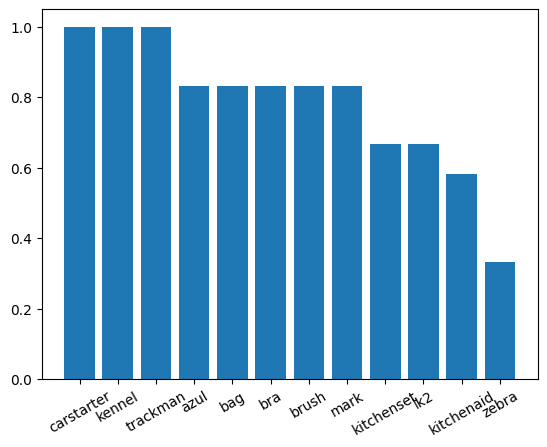

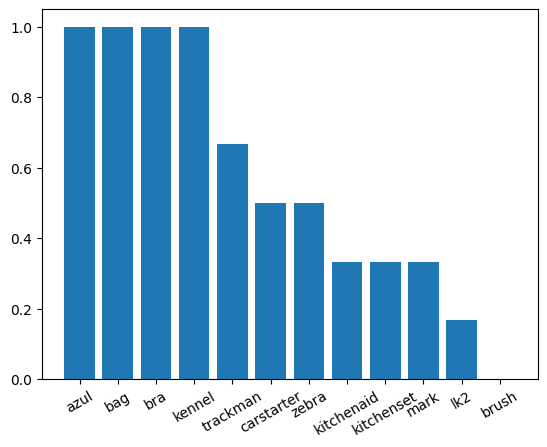

In [6]:
better = []
informative = []

for child in ctx.children:
    entry = child.inputs["entry"]
    name = os.path.basename(entry["filename"][:-5])
    b = child.result["marketplace"]
    o1 = b["Origin.Ai"]
    o2 = b["Origin.Human"]
    better.append((name, o1 / (o1 + o2)))

    b = child.result["ab"]
    o1 = b["Origin.Ai"]
    o2 = b["Origin.Human"]
    informative.append((name, o1 / (o1 + o2)))

plt.figure()
better.sort(key=lambda x: x[0])
better.sort(key=lambda x: -x[1])
plt.bar(x=[x[0] for x in better], height=[x[1] for x in better])
plt.xticks(rotation=30)

plt.figure()
informative.sort(key=lambda x: x[0])
informative.sort(key=lambda x: -x[1])
plt.bar(x=[x[0] for x in informative], height=[x[1] for x in informative])
plt.xticks(rotation=30)

None